In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import scipy

# Quantizer without noise

In [2]:
points = []
centroids = []
num_points = 10**5
num_centroids = 2
e=0.0001

for i in range(num_points):
    points.append(np.random.normal())
for i in range(num_centroids):
    centroids.append(np.random.normal())

points = np.array(points)
centroids = np.array(centroids)

In [3]:
def grouping(point_array, centroid_array):
    #grouping the centroids into groups
    grouping = []
    return_list = {}
    centroid_array = np.sort(centroid_array)
    for i in range(len(centroid_array)-1):
        midpoint = (centroid_array[i]+centroid_array[i+1])/2
        grouping.append(midpoint)
    for i in range(len(grouping)+1):
        if i ==0:
            return_list[i] = point_array[np.where(point_array<grouping[i])]
        if i == len(grouping):
            return_list[i] = point_array[np.where(point_array>grouping[i-1])]
        if i!=0 and i!= len(grouping):
            return_list[i] = point_array[np.where(np.logical_and(point_array>grouping[i-1], point_array<grouping[i]))]
        
    return return_list

In [4]:
def new_centroids(points):
    new_centroid_points = []
    for i in range(len(points)):
        new_centroid_points.append(points[i].mean())
    return new_centroid_points

In [5]:
def distortion(points, centroids):
    total_dis = 0
    for i in range(len(points)):
        dis = np.square(np.array(points[i])-centroids[i]).sum() #distortion for each cluster
        total_dis = total_dis + dis
    return total_dis

In [6]:
def lloydsalgorithm(point_array, centroid_array, distortion_list):
    previous_centroids = centroid_array
    groups = grouping(point_array, centroid_array)
    
    new_centroid_array = new_centroids(groups)
    new_groups = grouping(point_array, new_centroid_array)

    prev_dis = distortion(groups, previous_centroids)
    new_dis = distortion(new_groups, new_centroid_array)
    distortion_list.append(prev_dis)

    if np.abs(prev_dis-new_dis)/prev_dis<e:
        return new_centroid_array, distortion_list
    else:
        return lloydsalgorithm(point_array, new_centroid_array, distortion_list)
    


In [7]:
centroids, distortions =lloydsalgorithm(points, centroids, [])

In [8]:
df = pd.DataFrame(distortions)

Text(0, 0.5, 'Mean Squared Error')

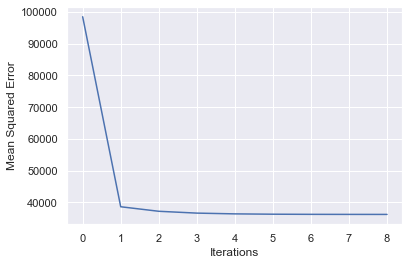

In [9]:
sns.set_theme()
ax = sns.lineplot(data = df, y=0, x=df.index,  markers=True, dashes=False)
ax.set_xlabel("Iterations")
ax.set_ylabel("Mean Squared Error")

# Quantizer with Noise

In [22]:
iterations = 10**5
num_centroids = 2
training_set = []
centroids = []
epsilon = 0.001

transition_matrix = np.matrix([[1 - epsilon, epsilon], [epsilon, 1-epsilon]])

for i in range(iterations):
    training_set.append(np.random.normal())

for i in range(num_centroids):
    centroids.append(np.random.normal())

In [44]:
def distortion(point, centroid, prob):
    return prob*(point - centroid)**2

In [36]:
transition_matrix.shape

(2, 2)

In [52]:
def ub_distortions(point, centroids, transition_matrix):
    i, j = transition_matrix.shape
    distortions = []
    sum = 0
    for indexi in range(i):
        for indexj in range(j):
            sum = sum + distortion(point, centroids[indexj], transition_matrix[indexi,indexj])
        distortions.append(sum)
    return np.array(distortions).min()

In [ ]:
def grouping_w_noise(centroids, points, transition_matrix):
    distance = {}
    dimension1, dimension2 = transition_matrix.shape
    for i in range(dimension1):
        for j in range(dimension2):
            prob = transition_matrix(i,j)
            
            pass

In [ ]:
def new_centroids_w_noise():
    #weighted average for each section
    
    pass

In [ ]:
def distortion_w_noise():
    pass

In [ ]:
def lloydsalgorithm_w_noise():
    pass